/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


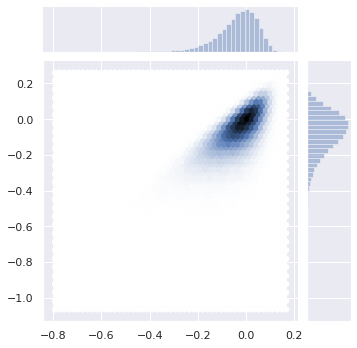

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
dataset = np.zeros(shape=(300000,2))
for j in range(0,300000):
    x1, x2 = np.random.exponential(size=2)
    x2 *= x1
    dataset[j][0] = np.log(x1) / 15
    dataset[j][1] = np.log(x2) / 15
sns.jointplot(dataset[:,0],dataset[:,1],kind='hex',size=5)

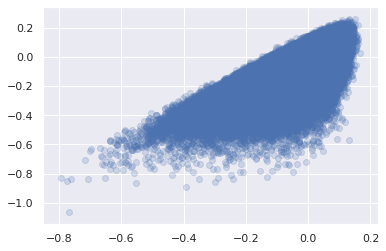

In [2]:
plt.scatter(dataset[:,0],dataset[:,1],alpha=0.2)

In [3]:
dataset = np.array(dataset)
dataset=dataset.reshape(-1,1,2)
dataset[0].shape

(1, 2)

In [4]:
dataset.shape

(300000, 1, 2)

# larger learning rate with wider network

Using TensorFlow backend.


Epoch: 0


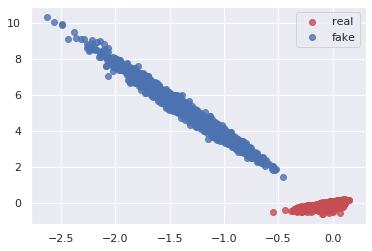

Epoch: 500


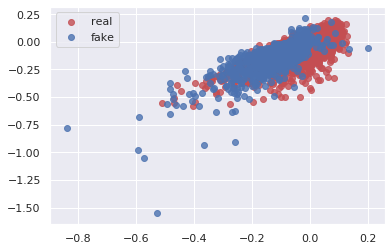

Epoch: 1000


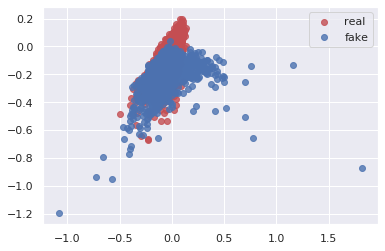

Epoch: 1500


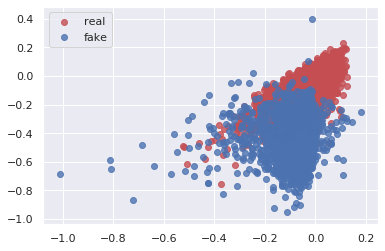

Epoch: 2000


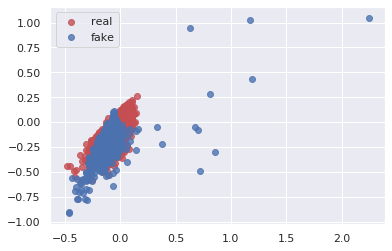

Epoch: 2500


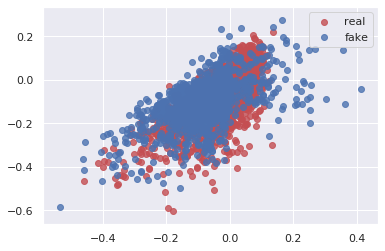

Epoch: 3000


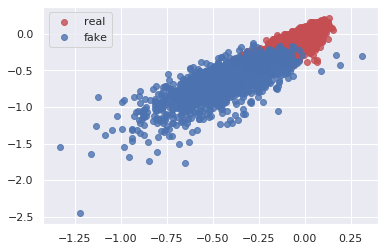

Epoch: 3500


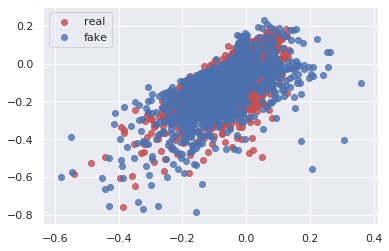

Epoch: 4000


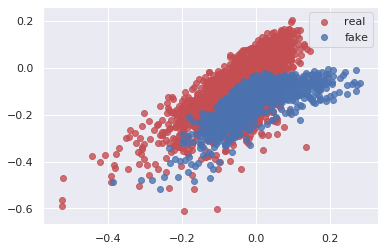

Epoch: 4500


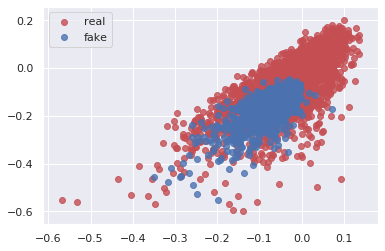

Epoch: 5000


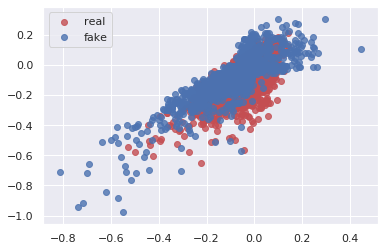

Epoch: 5500


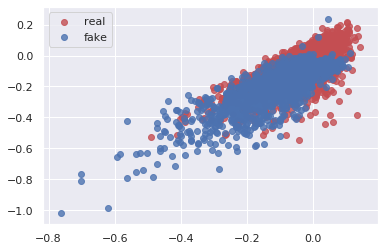

Epoch: 6000


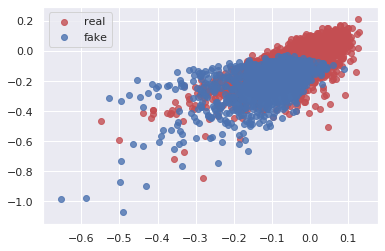

Epoch: 6500


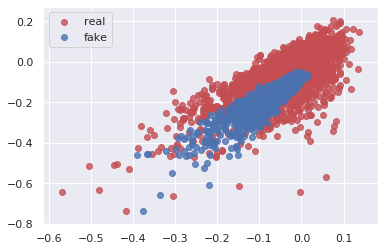

Epoch: 7000


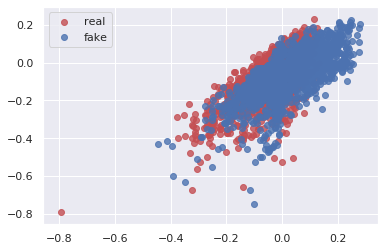

Epoch: 7500


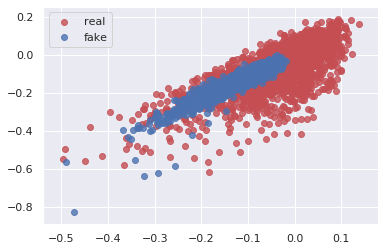

Epoch: 8000


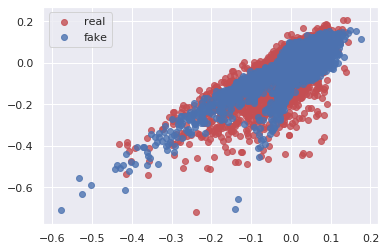

Epoch: 8500


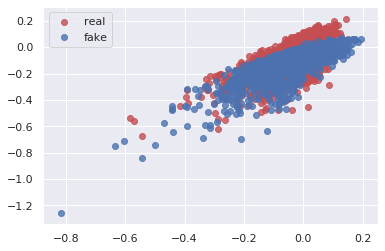

Epoch: 9000


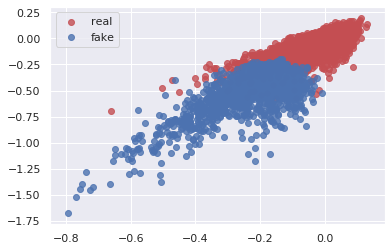

Epoch: 9500


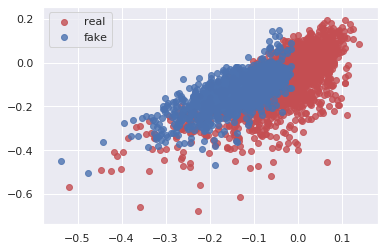

In [5]:
import seaborn as sns, numpy as np
from scipy.stats import entropy
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand,randint
from numpy.random import randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from matplotlib import pyplot
from keras import optimizers
import tensorflow as tf
from numpy.random import random, choice
m1=[[],[]]
m2=[[],[]]
real_shuffle_acc=[[],[]]
fake_shuffle_acc=[[],[]]
g_loss=[[],[]]
d_loss=[[],[]]

import warnings
warnings.filterwarnings('ignore')

# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    model.add(Dense(1000, input_shape=(1,2)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(5000))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(5000))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.RMSprop(lr=0.002, decay=1e-10)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(3000, input_shape=[latent_dim]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(3000))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(3000))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(2))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((1,2)))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = optimizers.Adam(lr=0.001, decay=1e-10)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# generate n real samples with class labels
def generate_real_samples(n_samples):
    dataset = np.zeros(shape=(n_samples,2))
    for j in range(n_samples):
        x1, x2 = np.random.exponential(size=2)
        x2 *= x1
        dataset[j][0] = np.log(x1) / 15
        dataset[j][1] = np.log(x2) / 15
    
    dataset = dataset.reshape(-1,1,2)
    y=ones((n_samples,1))
    return dataset, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=2000):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    x_fake = x_fake.reshape(n,2)
    x_real = x_real.reshape(n,2)
    plt.scatter(x_real[:,0],x_real[:,1],alpha=0.8,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,1],alpha=0.8,color='b', label='fake')
#     sns.jointplot(x_fake[:,0],x_fake[:,1],kind='hex',height=5,gridsize=30)
#     sns.jointplot(x_real[:,0],x_real[:,1],kind='hex',height=5,gridsize=30)   
    print("Epoch:",epoch)
#     print("Entropy on marginal 1:", entropy(x_fake[:,0],x_real[:,0]))
#     print("Entropy on marginal 2:", entropy(x_fake[:,1],x_real[:,1]))
    plt.legend()
    plt.show()

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + 0.3 + (random(y.shape) * 0.3)


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256, n_eval=500):
    # determine half the size of one batch, for updating the discriminator
    bat_per_eop = int(5000 / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_eop):
            # prepare real samples
            x_real, y_real = generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_real = smooth_positive_labels(y_real)
            y_fake = smooth_negative_labels(y_fake)
            # update discriminator
            loss_1=d_model.train_on_batch(x_real, y_real)
            loss_2=d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            y_gan = smooth_positive_labels(y_gan)
            # update the generator via the discriminator's error
            loss_3=gan_model.train_on_batch(x_gan, y_gan)
            d_loss.append(loss_1[0]+loss_2[0])
            g_loss.append(loss_3)
            # evaluate the model every n_eval epochs
        x_fake = x_fake.reshape(-1,2)
        x_real = x_real.reshape(-1,2)
        m1[0].append(i)
        m1[1].append(entropy(x_fake[:,0],x_real[:,0]))
        m2[0].append(i)
        m2[1].append(entropy(x_fake[:,1],x_real[:,1])) 
        if (i) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
            d_loss[1].append(loss_1[0]+loss_2[0])
            g_loss[1].append(loss_3)
            d_loss[0].append(i)
            g_loss[0].append(i)

with tf.device('/device:GPU:3'):

    # size of the latent space
    latent_dim = 30
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    # train model
    train(generator, discriminator, gan_model, latent_dim)

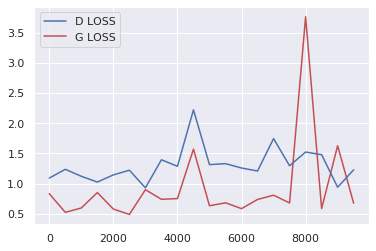

In [6]:
line_down, =pyplot.plot(g_loss[0],g_loss[1],color='r',label="G LOSS")
line_up, =pyplot.plot(d_loss[0],d_loss[1],color='b',label="D LOSS")
pyplot.legend(handles=[line_up, line_down])

# Smaller learning rate with normal network

Epoch: 0


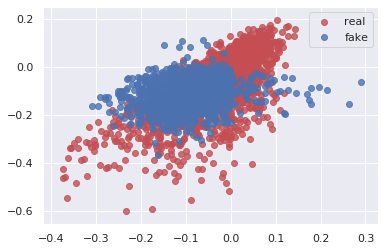

Epoch: 500


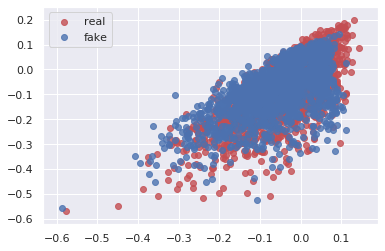

Epoch: 1000


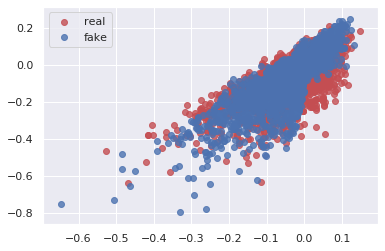

Epoch: 1500


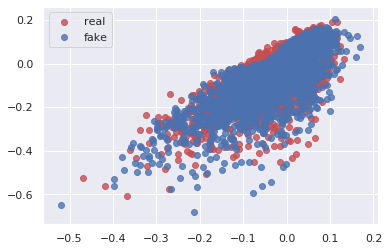

Epoch: 2000


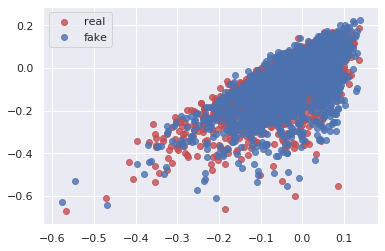

Epoch: 2500


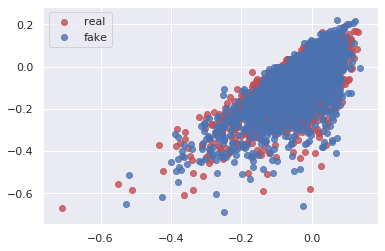

Epoch: 3000


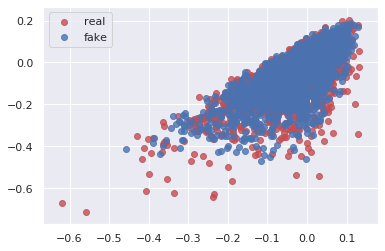

Epoch: 3500


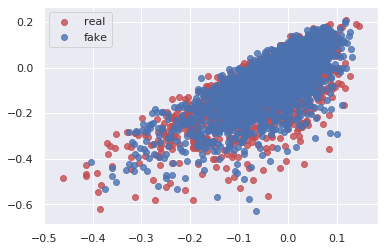

Epoch: 4000


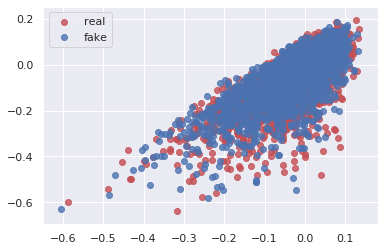

Epoch: 4500


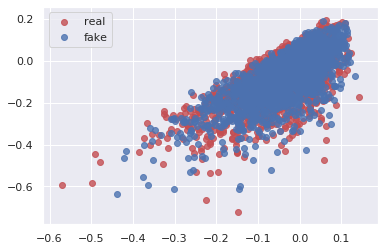

Epoch: 5000


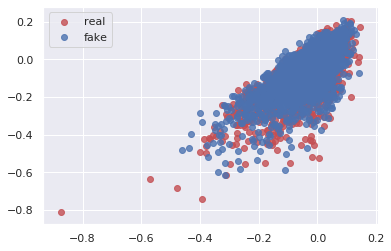

Epoch: 5500


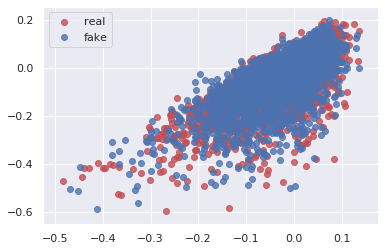

Epoch: 6000


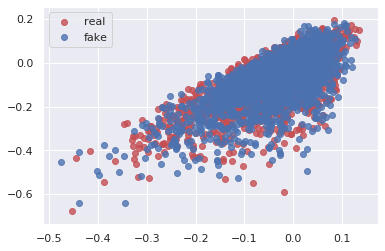

Epoch: 6500


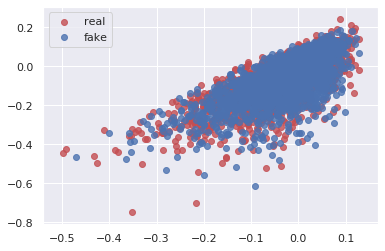

Epoch: 7000


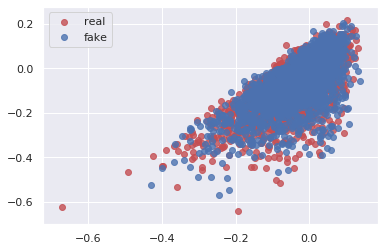

Epoch: 7500


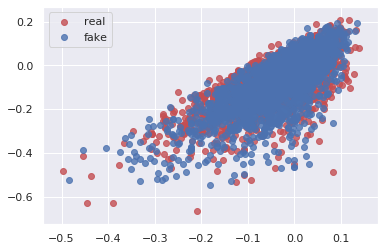

Epoch: 8000


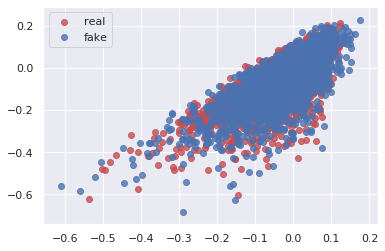

Epoch: 8500


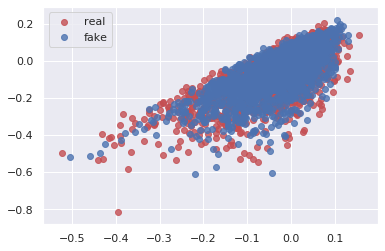

Epoch: 9000


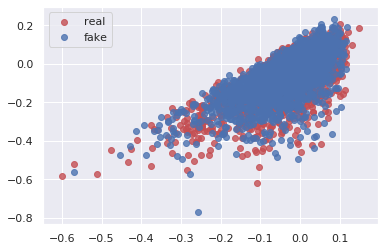

Epoch: 9500


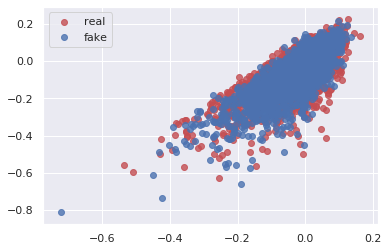

In [7]:
import seaborn as sns, numpy as np
from scipy.stats import entropy
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand,randint
from numpy.random import randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from matplotlib import pyplot
from keras import optimizers
import tensorflow as tf
from numpy.random import random, choice
m1=[[],[]]
m2=[[],[]]
real_shuffle_acc=[[],[]]
fake_shuffle_acc=[[],[]]
g_loss=[[],[]]
d_loss=[[],[]]

import warnings
warnings.filterwarnings('ignore')

# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    model.add(Dense(100, input_shape=(1,2)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.RMSprop(lr=0.0002, decay=1e-10)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(100, input_shape=[latent_dim]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(300))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(2))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((1,2)))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = optimizers.Adam(lr=0.0001, decay=1e-10)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# generate n real samples with class labels
def generate_real_samples(n_samples):
    dataset = np.zeros(shape=(n_samples,2))
    for j in range(n_samples):
        x1, x2 = np.random.exponential(size=2)
        x2 *= x1
        dataset[j][0] = np.log(x1) / 15
        dataset[j][1] = np.log(x2) / 15
    
    dataset = dataset.reshape(-1,1,2)
    y=ones((n_samples,1))
    return dataset, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=2000):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    x_fake = x_fake.reshape(n,2)
    x_real = x_real.reshape(n,2)
    plt.scatter(x_real[:,0],x_real[:,1],alpha=0.8,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,1],alpha=0.8,color='b', label='fake')
#     sns.jointplot(x_fake[:,0],x_fake[:,1],kind='hex',height=5,gridsize=30)
#     sns.jointplot(x_real[:,0],x_real[:,1],kind='hex',height=5,gridsize=30)   
    print("Epoch:",epoch)
#     print("Entropy on marginal 1:", entropy(x_fake[:,0],x_real[:,0]))
#     print("Entropy on marginal 2:", entropy(x_fake[:,1],x_real[:,1]))
    plt.legend()
    plt.show()

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + 0.3 + (random(y.shape) * 0.3)


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256, n_eval=500):
    # determine half the size of one batch, for updating the discriminator
    bat_per_eop = int(5000 / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_eop):
            # prepare real samples
            x_real, y_real = generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_real = smooth_positive_labels(y_real)
            y_fake = smooth_negative_labels(y_fake)
            # update discriminator
            loss_1=d_model.train_on_batch(x_real, y_real)
            loss_2=d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            y_gan = smooth_positive_labels(y_gan)
            # update the generator via the discriminator's error
            loss_3=gan_model.train_on_batch(x_gan, y_gan)
            d_loss.append(loss_1[0]+loss_2[0])
            g_loss.append(loss_3)
            # evaluate the model every n_eval epochs
        x_fake = x_fake.reshape(-1,2)
        x_real = x_real.reshape(-1,2)
        m1[0].append(i)
        m1[1].append(entropy(x_fake[:,0],x_real[:,0]))
        m2[0].append(i)
        m2[1].append(entropy(x_fake[:,1],x_real[:,1])) 
        if (i) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
            d_loss[1].append(loss_1[0]+loss_2[0])
            g_loss[1].append(loss_3)
            d_loss[0].append(i)
            g_loss[0].append(i)

with tf.device('/device:GPU:3'):

    # size of the latent space
    latent_dim = 30
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    # train model
    train(generator, discriminator, gan_model, latent_dim)

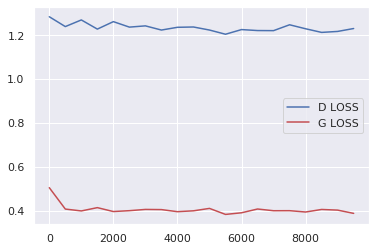

In [8]:
line_down, =pyplot.plot(g_loss[0],g_loss[1],color='r',label="G LOSS")
line_up, =pyplot.plot(d_loss[0],d_loss[1],color='b',label="D LOSS")
pyplot.legend(handles=[line_up, line_down])